In [45]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
import pandas as pd
from src.gpt_prompt import get_sentiment_general, get_sentiment_general_parallel, get_risk_score
import datetime

In [46]:
df_news = pd.read_csv("../data/apple_2023/news_apple_2023.csv", index_col=0)
df_price = pd.read_csv("../data/apple_2023/price_apple_2023.csv", index_col=0)
df_news["date"] = pd.to_datetime(df_news['date'])
df_price["date"] = pd.to_datetime(df_price['date'])
print(df_news.head())
print(df_price.head())

                 date                                               news
0 2023-01-01 00:19:34  Title: iPhone 15 release date speculation: Her...
1 2023-01-01 01:25:56  Title: Apple (NASDAQ:AAPL) PT Set at $184.00 b...
2 2023-01-01 01:32:30  Title: 2023 Dividend Growth Portfolio Review A...
3 2023-01-01 02:52:26  Title: Tracking Terry Smith's Fundsmith 13F Po...
4 2023-01-01 03:10:16  Title: 5 appliances and smart home gadgets tha...
                 date       price
0 2023-01-03 09:31:00  129.058631
1 2023-01-03 09:32:00  128.929353
2 2023-01-03 09:33:00  128.740410
3 2023-01-03 09:34:00  129.307241
4 2023-01-03 09:35:00  129.108353


In [47]:
dfs = []
for i in range(1, 7):
    df_score = pd.read_csv(f"../data/apple_2023/news_score_apple_2023_{i}.csv", index_col=0)
    print(df_score.shape)
    df_score = df_score[["date", "score"]]
    df_score["date"] = pd.to_datetime(df_score['date'])
    dfs.append(df_score)
    
df_score = pd.concat(dfs)
df_score.reset_index(drop = True, inplace = True)
df_score.to_csv("../data/apple_2023/news_score_apple_2023_all.csv")
df_score


# df_score = pd.read_csv(f"../data/apple_2023/news_score_apple_2023_{1}.csv", index_col=0)
# print(df_score.shape)
# df_score = df_score[["date", "score"]]
# df_score["date"] = pd.to_datetime(df_score['date'])

(2000, 3)
(1320, 3)
(332, 3)
(332, 3)
(1480, 3)
(240, 3)


,date,score
0,2023-01-01 00:19:34,1
1,2023-01-01 05:54:24,1
2,2023-01-01 14:20:37,0
3,2023-01-02 05:08:21,1
4,2023-01-02 09:50:11,1
...,...,...
5699,2023-01-20 19:17:57,1
5700,2023-01-21 02:07:00,0
5701,2023-01-21 08:03:37,0
5702,2023-01-21 11:52:29,0


In [48]:
df_score = df_score.sort_values("date")
df_score.reset_index(drop = True, inplace = True)
df_score

,date,score
0,2023-01-01 00:19:34,1
1,2023-01-01 01:25:56,1
2,2023-01-01 01:32:30,1
3,2023-01-01 02:52:26,-1
4,2023-01-01 03:10:16,1
...,...,...
5699,2023-11-29 14:47:43,-1
5700,2023-11-30 10:50:15,0
5701,2023-11-30 10:59:20,1
5702,2023-12-01 11:02:32,0


In [49]:
df_score["score"].value_counts()

 1    3095
 0    1575
-1    1034
Name: score, dtype: int64

In [50]:
date_price_dict = df_price.set_index('date')['price'].to_dict()
# date_price_dict

In [51]:
def find_whole_minute_time_after_n_minutes(time, n):
    new_time = time + pd.Timedelta(minutes=n)
    if new_time.second > 0:
        new_time += pd.Timedelta(minutes=1)
        new_time = new_time.replace(second=0, microsecond=0)
    return new_time

In [52]:
df_news.shape

(33152, 2)

In [53]:

columns = ["price_now", "price_in5", "price_in10", "price_in30", "price_in60"]
deltas = [0, 5, 10, 30, 60]
pd_price = np.zeros((df_news.shape[0], 5))

for i in range(df_news.shape[0]):
    time = df_news["date"][i]
    for j in range(5):
        delta = deltas[j]
        new_time = find_whole_minute_time_after_n_minutes(time, delta)
        if new_time in date_price_dict:
            pd_price[i, j] = date_price_dict[new_time]

In [54]:
pd_price = pd.DataFrame(pd_price, columns=columns)
result_df = pd.concat([df_news, pd_price], axis=1)

In [55]:
result_df.replace(0, pd.NA, inplace=True)
result_df = result_df.merge(df_score, on='date', how='left')
result_df["score"] = result_df["score"].astype(float)
result_df = result_df.dropna()



return_cols = ["return_in5", "return_in10", "return_in20", "return_in60"]
price_cols = ["price_in5", "price_in10", "price_in30", "price_in60"]

for i in range(4):
    result_df[return_cols[i]] = (result_df[price_cols[i]] - result_df["price_now"]) / result_df["price_now"]
    result_df[return_cols[i]] = result_df[return_cols[i]].astype(float)
for col in price_cols:
    result_df.drop(col, axis=1, inplace=True)
result_df

,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
110,2023-01-03 09:42:30,Title: Apple’s Magic Keyboard for 12.9-inch M2...,129.75474,1.0,-0.009235,-0.021383,-0.032955,-0.036787
111,2023-01-03 09:43:27,Title: Thinking about trading options or stock...,129.75474,1.0,-0.014102,-0.019697,-0.034948,-0.037784
114,2023-01-03 10:01:29,Title: What’s Ahead for Wall Street in 2023?. ...,126.313972,0.0,-0.003464,-0.006456,-0.011809,-0.010313
115,2023-01-03 10:06:48,Title: Foxconn's Largest iPhone Plant In China...,125.876418,1.0,-0.003002,-0.004424,-0.011771,-0.009480
120,2023-01-03 10:48:17,Title: Elon Musk Expresses Dissatisfaction Ove...,124.921754,-1.0,-0.001911,-0.000756,-0.003503,-0.006846
...,...,...,...,...,...,...,...,...
32931,2023-11-29 14:47:43,Title: What's Going On With Apple Stock?. Desc...,189.215,-1.0,0.000053,0.000555,-0.000502,0.000898
33030,2023-11-30 10:50:15,"Title: Getting Closer: The Bloomberg Close, Eu...",188.52,0.0,-0.000477,0.001804,0.000212,-0.000743
33031,2023-11-30 10:59:20,Title: New app brings power of video to job ca...,188.76,1.0,-0.000477,-0.001166,-0.001483,-0.002728
33130,2023-12-01 11:02:32,Title: Get A $200 Pair Of Sennheiser Noise-Can...,190.665,0.0,-0.000498,0.000839,0.000708,0.002150


In [56]:
result_df = result_df.dropna()

In [57]:
result_df.describe(include='all')

/var/folders/v0/_fszh3l96cz8c79p9psn63y80000gn/T/ipykernel_37075/3235814888.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result_df.describe(include='all')


,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
count,1563,1563,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000
unique,1550,1542,1341.000000,NaN,NaN,NaN,NaN,NaN
top,2023-01-18 11:31:36,Title: Check Out What Whales Are Doing With AA...,134.796559,NaN,NaN,NaN,NaN,NaN
freq,4,4,5.000000,NaN,NaN,NaN,NaN,NaN
first,2023-01-03 09:42:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-12-01 11:08:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.454894,0.000040,0.000081,0.000141,0.000118
std,NaN,NaN,NaN,0.737495,0.001600,0.002268,0.003687,0.004833
min,NaN,NaN,NaN,-1.000000,-0.014102,-0.021383,-0.034948,-0.037784
25%,NaN,NaN,NaN,0.000000,-0.000712,-0.001017,-0.001660,-0.002362


In [58]:
result_df.dtypes

date           datetime64[ns]
news                   object
price_now              object
score                 float64
return_in5            float64
return_in10           float64
return_in20           float64
return_in60           float64
dtype: object

In [59]:
correlation_matrix = result_df[["score", 'return_in5', 'return_in10', 'return_in20', 'return_in60']].corr()

In [60]:
correlation_matrix

,score,return_in5,return_in10,return_in20,return_in60
score,1.000000,-0.012486,-0.025892,-0.042321,-0.053942
return_in5,-0.012486,1.000000,0.733346,0.466245,0.382489
return_in10,-0.025892,0.733346,1.000000,0.636471,0.498122
return_in20,-0.042321,0.466245,0.636471,1.000000,0.764345
return_in60,-0.053942,0.382489,0.498122,0.764345,1.000000


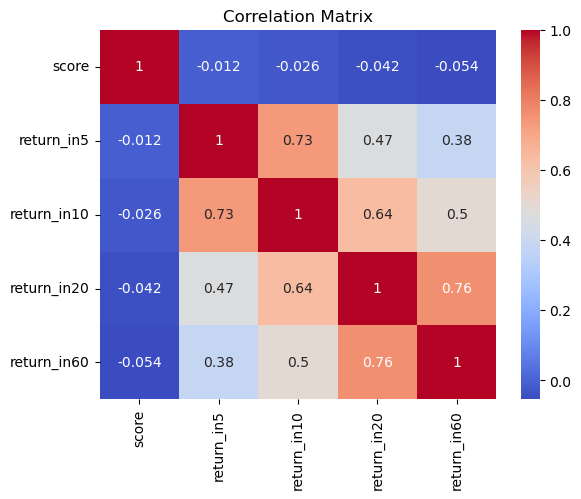

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

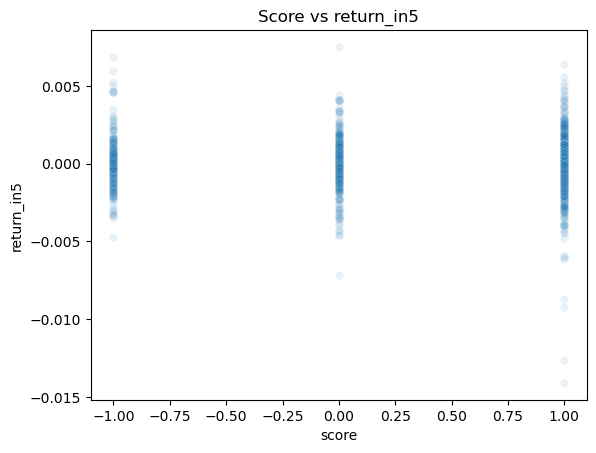

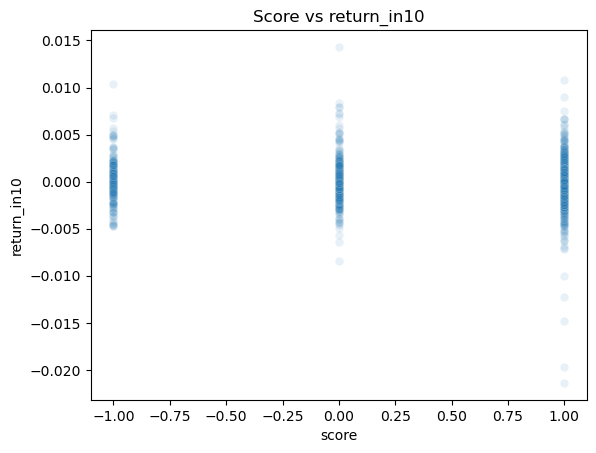

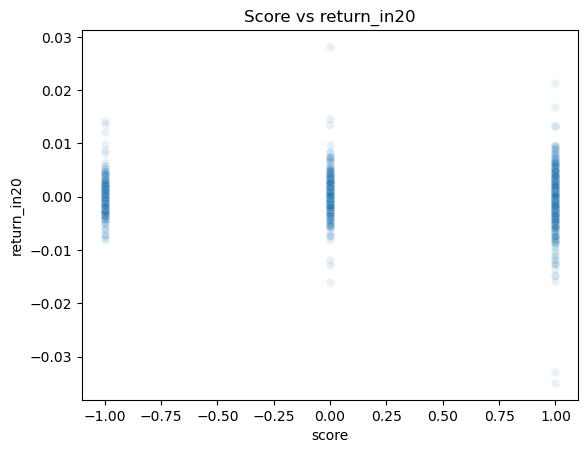

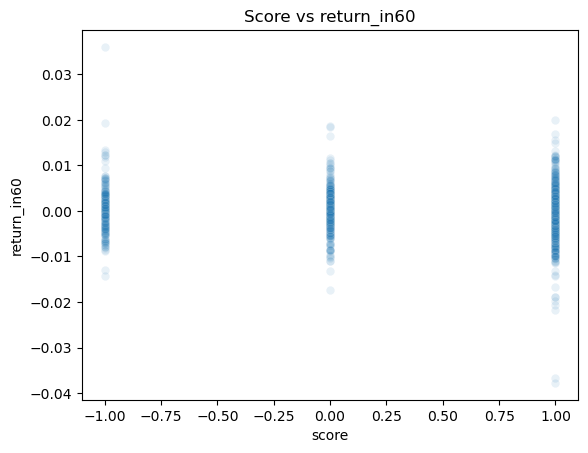

In [62]:
for return_col in ['return_in5', 'return_in10', 'return_in20', 'return_in60']:
    sns.scatterplot(x='score', y=return_col, data=result_df, alpha=0.1)
    plt.title(f'Score vs {return_col}')
    plt.show()

In [63]:
np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]]).shape

(1563, 4)

In [64]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X = np.array(result_df["score"]).reshape(-1,1)
y = np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]])
lr.fit(X, y)

LinearRegression()

In [65]:
lr.coef_

array([[-2.70812375e-05],
       [-7.96250416e-05],
       [-2.11567974e-04],
       [-3.53533775e-04]])

In [66]:
return_names = ["return_in5", "return_in10","return_in20","return_in60"]
for name in return_names:
    for j in [-1, 0, 1]:
        print(f"When score is {j}, the mean {name} is {result_df[result_df['score'] == j][name].mean()*10000}")
    

When score is -1, the mean return_in5 is 0.7594107336767044
When score is 0, the mean return_in5 is 0.5612601940660776
When score is 1, the mean return_in5 is 0.2428903960587988
When score is -1, the mean return_in10 is 1.2829560628504757
When score is 0, the mean return_in10 is 1.9752955610094225
When score is 1, the mean return_in10 is 0.20475790514233425
When score is -1, the mean return_in20 is 2.6768923337289654
When score is 0, the mean return_in20 is 4.514692885849113
When score is 1, the mean return_in20 is -0.18855336806783546
When score is -1, the mean return_in60 is 4.665448232516112
When score is 0, the mean return_in60 is 4.755786408410163
When score is 1, the mean return_in60 is -1.1525687531579685
